In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split

In [1]:
from google.colab import files


In [ ]:
import zipfile

os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Download the dataset (this is the resized 224x224 version)
!kaggle datasets download -d nih-chest-xrays/data

Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/data
License(s): CC0-1.0
^C


In [ ]:
# Unzip the dataset
!unzip -q data.zip -d /content/nih_dataset

In [ ]:
# Paths for Colab
base_dir = '/content/nih_dataset'
images_dir = os.path.join(base_dir, 'images-224/images-224')
bbox_csv_path = os.path.join(base_dir, 'BBox_List_2017_Official_NIH.csv')
metadata_csv_path = os.path.join(base_dir, 'Data_Entry_2017.csv')

# Load CSVs
bboxes_df = pd.read_csv(bbox_csv_path)
metadata_df = pd.read_csv(metadata_csv_path)

In [ ]:
# Basic data exploration
print("Bounding Box DataFrame shape:", bboxes_df.shape)
print("Metadata DataFrame shape:", metadata_df.shape)

Bounding Box DataFrame shape: (984, 9)
Metadata DataFrame shape: (112120, 12)


In [ ]:
bboxes_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


In [ ]:
bboxes_df['Finding Label'].unique()

array(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass',
       'Nodule', 'Pneumonia', 'Pneumothorax'], dtype=object)

In [ ]:
metadata_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143,NaN


In [ ]:
# Focus on one disease for now
target_disease = 'Pneumothorax'
# Filter metadata for images with this disease
targets_df = bboxes_df[bboxes_df['Finding Label'].str.contains(target_disease)]

In [ ]:
def create_mask(image_name, bboxes_df, img_size=(224, 224)):
    mask = np.zeros((img_size[0], img_size[1]), dtype=np.uint8)
    image_bboxes = bboxes_df[bboxes_df['Image Index'] == image_name]
    scale_factor = 224/1024
    for _, row in image_bboxes.iterrows():
        # Extract bbox coordinates
        x = int(int(row['Bbox [x'])*scale_factor)
        y = int(int(row['y'])*scale_factor)
        w = int(int(row['w'])*scale_factor)
        h = int(int(row['h]'])*scale_factor)
        # Draw rectangle on mask
        cv2.rectangle(mask, (x, y), (x + w, y + h), 255, thickness=-1)

    return mask

In [ ]:
# Loading images and their corresponding masks
def load_images_and_masks():
    images = []
    masks = []
    for idx, row in targets_df.iterrows():
        filename = row['Image Index']
        img_path = os.path.join(images_dir, filename)
        # Load image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, (224, 224))
        # Normalize
        img_resized = img_resized / 255.0
        images.append(img_resized)

        # Create mask from bounding boxes
        mask = create_mask(filename, bboxes_df)
        mask = mask/ 255.0
        masks.append(mask)
    return np.array(images), np.array(masks)

X, y = load_images_and_masks()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

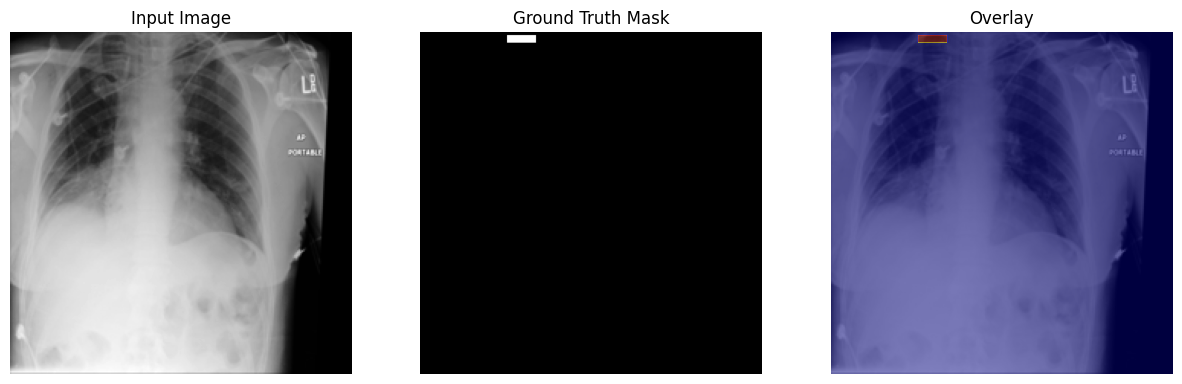

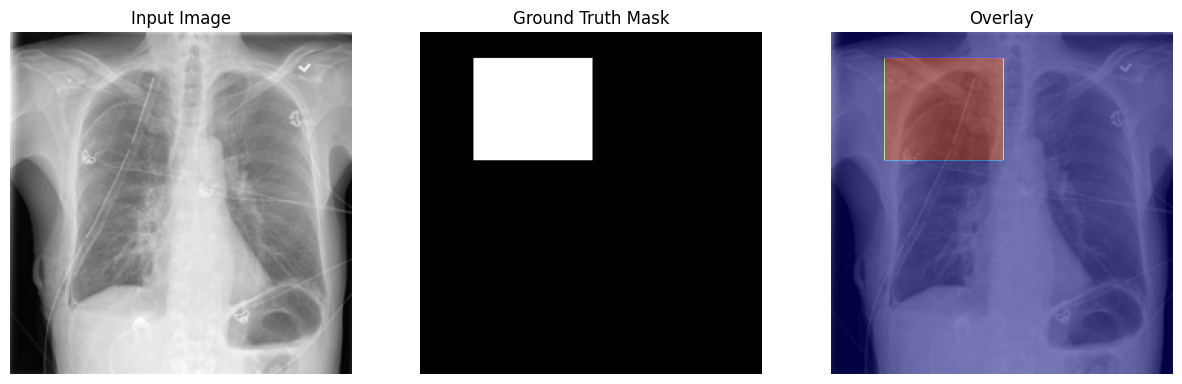

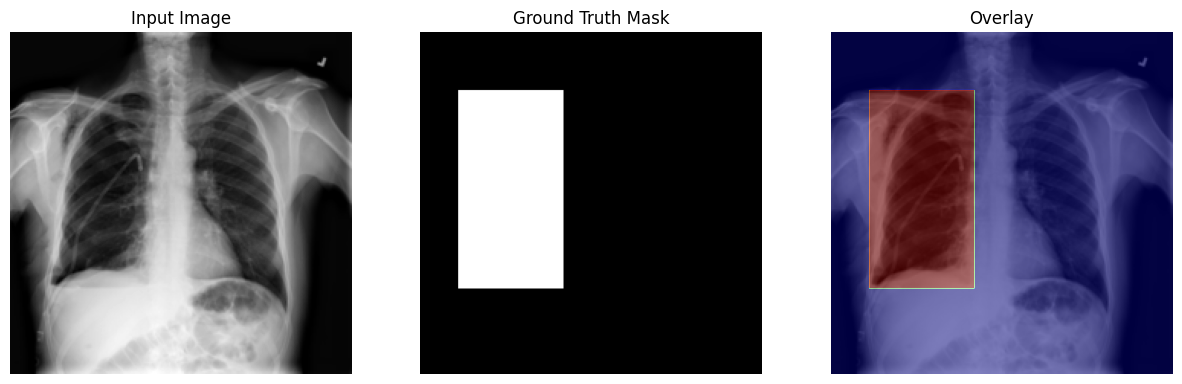

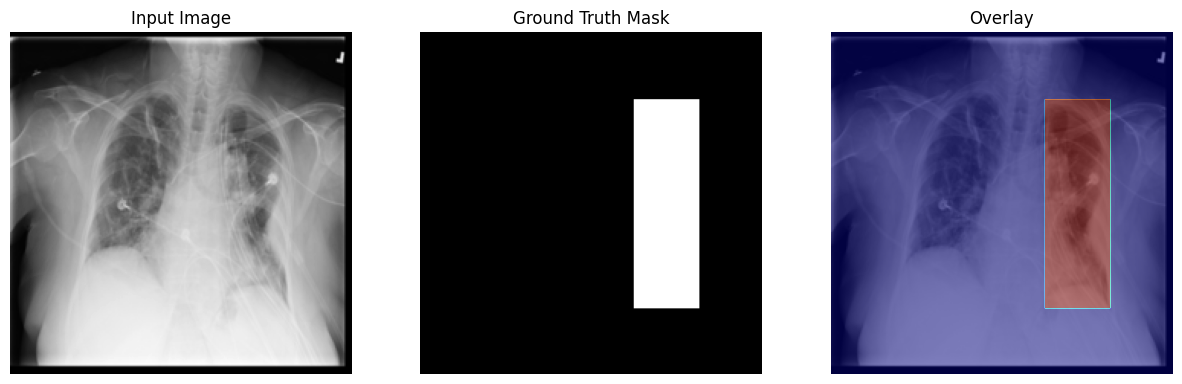

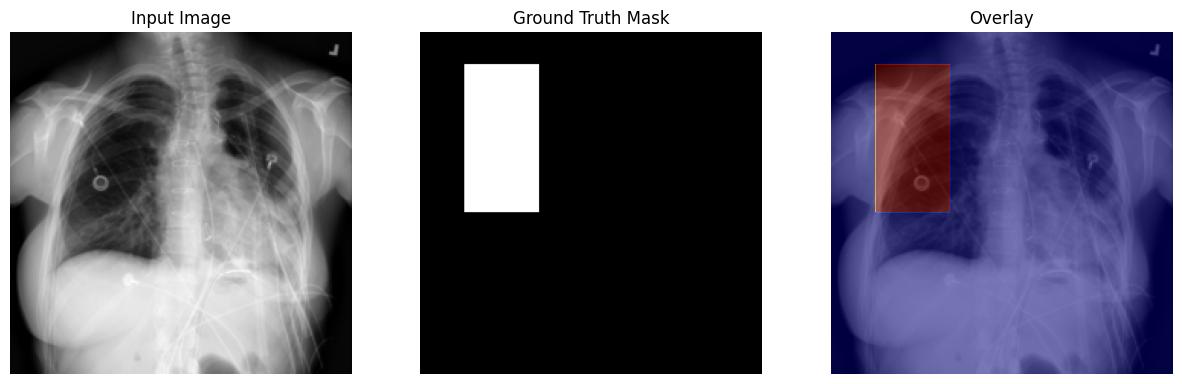

In [ ]:
import random

def show_samples_with_overlay(X_train, y_train, model=None, num_samples=3):

    indices = random.sample(range(len(X_train)), num_samples)

    for idx in indices:
        img = X_train[idx].squeeze()  # shape (H, W)
        mask = y_train[idx].squeeze()  # shape (H, W)

        plt.figure(figsize=(15, 5))

        # Plot original image
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title('Input Image')
        plt.axis('off')

        # Plot ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Plot overlay of mask on image
        if model:
            # Get prediction
            pred_mask = model.predict(X_train[idx][np.newaxis, ...])[0]
            overlay_mask = pred_mask.squeeze()
        else:
            overlay_mask = None

        # If model provided, overlay the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(img, cmap='gray')
        if overlay_mask is not None:
            plt.imshow(overlay_mask, cmap='jet', alpha=0.5)
        else:
            plt.imshow(mask, cmap='jet', alpha=0.5)
        plt.title('Overlay' + (' with Prediction' if model else ''))
        plt.axis('off')

        plt.show()

show_samples_with_overlay(X_train, y_train, model=None, num_samples=5)

In [ ]:
def preprocess_and_augment(image, mask):
    # Normalize
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0

    # Expand dims for compatibility
    image = tf.expand_dims(image, -1)
    mask = tf.expand_dims(mask, -1)

    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.1)

    return tf.squeeze(image, -1), tf.squeeze(mask, -1)

In [ ]:
def load_dataset(X, y, augment=False, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if augment:
        dataset = dataset.map(preprocess_and_augment, num_parallel_calls=AUTOTUNE)
    else:
        dataset = dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
    return dataset.shuffle(100).batch(batch_size).prefetch(AUTOTUNE)


train_ds = load_dataset(X_train, y_train, augment=True)
val_ds = load_dataset(X_val, y_val, augment=False)

In [ ]:
def unet_model(input_size=(224, 224, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.nn.sigmoid(y_pred)

    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

# Training

In [ ]:
model = unet_model()
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 224, 224, 64)   │            640 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, 224, 224, 64)   │         36,928 │ conv2d_95[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 112, 112, 64)   │              0 │ conv2d_96[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)        │ (None, 112, 112, 128)  │        147,584 │ conv2d_97[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 56, 56, 128)    │              0 │ conv2d_98[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_99 (Conv2D)        │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_100 (Conv2D)       │ (None, 56, 56, 256)    │        590,080 │ conv2d_99[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 28, 28, 256)    │              0 │ conv2d_100[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_101 (Conv2D)       │ (None, 28, 28, 512)    │      1,180,160 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)       │ (None, 28, 28, 512)    │      2,359,808 │ conv2d_101[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 14, 14, 512)    │              0 │ conv2d_102[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_103 (Conv2D)       │ (None, 14, 14, 1024)   │      4,719,616 │ max_pooling2d_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_104 (Conv2D)       │ (None, 14, 14, 1024)   │      9,438,208 │ conv2d_103[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_20       │ (None, 28, 28, 512)    │      2,097,664 │ conv2d_104[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_20       

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Plotting the training & validation accuracy and loss
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

## U-net with binary_crossentropy Loss

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', dice_coef, tf.keras.metrics.MeanIoU(num_classes=2)]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_160']
Received: inputs=Tensor(shape=(None, 224, 224))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.0740 - dice_coef: 0.1105 - loss: 0.7055 - mean_io_u_4: 0.4697 - val_accuracy: 0.0832 - val_dice_coef: 0.0752 - val_loss: 0.7029 - val_mean_io_u_4: 0.4746
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.0973 - dice_coef: 0.1035 - loss: 0.7023 - mean_io_u_4: 0.4717 - val_accuracy: 0.1028 - val_dice_coef: 0.0752 - val_loss: 0.7001 - val_mean_io_u_4: 0.4746
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1334 - dice_coef: 0.1064 - loss: 0.6995 - mean_io_u_4: 0.4707 - val_accuracy: 0.1419 - val_dice_coef: 0.0752 - val_loss: 0.6975 - val_mean_io_u_4: 0.4746
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.1673 - dice_coef: 0.1070 - loss: 0.6971 - mean_io_u_4: 0.4707 - val_accuracy: 0.2771 - val_dice_coef: 0.0752 - val_loss: 0.6952 - val_mean_io_u_4: 0.4746
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3552 - dice_coef: 0.1104 - loss: 0.6947 - mean_io_u_4: 0.4697 - val_accuracy: 0.5693 - va

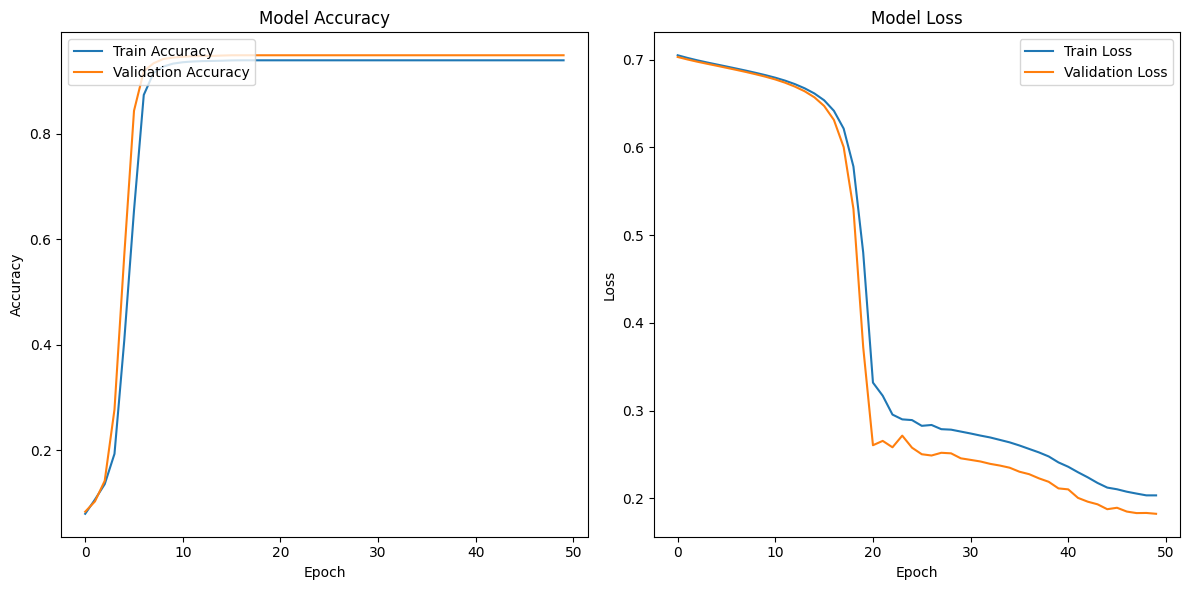

In [ ]:
# Plot training history
plot_training_history(history)

## U-net with Combined Loss

In [ ]:
model = unet_model()

from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=['accuracy', dice_coef, tf.keras.metrics.MeanIoU(num_classes=2)]
)

# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    callbacks=callbacks,
    epochs=50,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_192']
Received: inputs=Tensor(shape=(None, 224, 224))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.2789 - dice_coef: 0.1071 - loss: 1.5919 - mean_io_u_5: 0.4707 - val_accuracy: 0.9491 - val_dice_coef: 0.0752 - val_loss: 1.5855 - val_mean_io_u_5: 0.4746
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 874ms/step - accuracy: 0.9355 - dice_coef: 0.1164 - loss: 1.5569 - mean_io_u_5: 0.4678 - val_accuracy: 0.9493 - val_dice_coef: 0.0752 - val_loss: 1.5599 - val_mean_io_u_5: 0.4746
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 883ms/step - accuracy: 0.9418 - dice_coef: 0.1060 - loss: 1.5378 - mean_io_u_5: 0.4709 - val_accuracy: 0.9493 - val_dice_coef: 0.0752 - val_loss: 1.5067 - val_mean_io_u_5: 0.4746
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 919ms/step - accuracy: 0.9413 - dice_coef: 0.1070 - loss: 1.4602 - mean_io_u_5: 0.4706 - val_accuracy: 0.9493 - val_dice_coef: 0.0744 - val_loss: 1.2576 - val_mean_io_u_5: 0.4746
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 937ms/step - accuracy: 0.9368 - dice_coef: 0.1117 - loss: 1.2276 - mean_io_u_5: 0.4684 - val_accuracy:

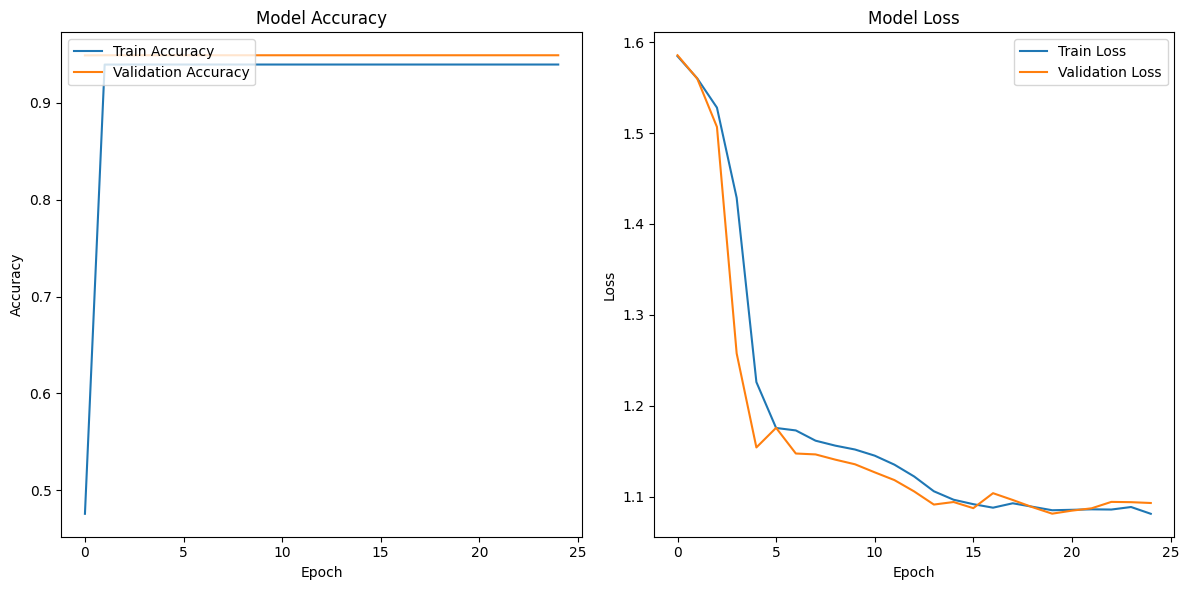

In [ ]:
plot_training_history(history)

# Evaluation

In [ ]:
best_model = model

In [ ]:
results = model.evaluate(X_val, y_val)
print(f'Loss: {results[0]:.4f}')
print(f'Accuracy: {results[1]:.4f}')
print(f'Mean IoU: {results[2]:.4f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.9493 - dice_coef: 0.0949 - loss: 1.0807 - mean_io_u_5: 0.4746
Loss: 1.0807
Accuracy: 0.9493
Mean IoU: 0.0949
